# Wyżarzanie kwantowe

W tej sekcji opiszemy algorytm wyżarzania kwantowego. 

## Kwantowy model Isinga

Kwantowy model Isinga jest definiowany w następujący sposób:

$$
\mathcal{H} =  \sum_{(i, j)} J_{ij} \sigma_i^z \sigma_j^z + \sum_{i=1}^{N} h_i \sigma_i^z
$$

gdzie $\sigma^z$ oraz $\sigma^x$ to macierze Pauliego zdefiniowane jako: 

$$
\sigma^z = \begin{bmatrix} 1 & 0 \\ 0 & -1 \end{bmatrix}, \quad \sigma^x = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix} 

$$ 
Warto pamiętać, że w przypadku działania macierzy Pauliego $\sigma^{\alpha}$ ($\alpha = x,z$) na spin $i$, zapis $\sigma^{\alpha}_i$ oznacza

\begin{equation*} \sigma^{\alpha}_i = I \otimes I \otimes \ldots \otimes I  \otimes \sigma^{\alpha} \otimes I \otimes \ldots \otimes I \end{equation*}

gdzie $\otimes$ jest iloczynem tensorowym (lub iloczynem Kroneckera), a $\sigma^{\alpha}$ jest $i$-tym czynnikiem.


### Związek między klasycznym a kwantowym modelem Isinga

Hamiltonian $\mathcal{H}$ jest olbrzymią macierzą o rozmiarze $2^n \times 2^n$, gdzie $n$ jest ilością spinów, natomiast klasyczny $H$, to jedynie pewna suma wskazująca wartość energii dla danego stanu. Jak, tak różne obiekty (liczba i macierz) mają się do siebie? Odpowiedź leży w specyfice mechaniki kwantowej.

W pewnym uproszczeniu, jeżeli Hamiltonian opisujący układ kwantowy jest macierzą, to wektory własne tej macierzy opisują stany, które ten układ może przyjąć a odpowiadające im własności własne są energiami tych stanów.

Przykładowo, przyjmijmy notację:
$$
\ket{\uparrow} = \begin{bmatrix} 1 \\ 0 \end{bmatrix} \quad \ket{\downarrow} = \begin{bmatrix} 0 \\ 1 \end{bmatrix} 
$$

Można pokazać, że wektory własne macierzy $\sigma^z$ to właśnie $\ket{\uparrow}$ i $\ket{\downarrow}$ z odpowiadającymi im wartościami własnymi $+1$ i $-1$. Zatem macierz $\sigma^z$ opisuje pojedyńczy spin. 

W ten sam sposób, wektory i własności własne kwantowego modelu Isinga bez pola poprzecznego odpowiadają

TODO dokończyć 



In [1]:
# Pokazanie, że oba modele dają te same stany
# pokażemy to wprost na bardzo małym przykładzie, na razie ignorując pole poprzeczne

import numpy as np
import qutip as qt
from itertools import product

J = {(1, 2): 0.5, (1, 3): -1, (2, 3): 0.75}
h = {1: 1, 2: -1, 3: 0.5}

# kwantowy
sigma_1 = qt.tensor([qt.sigmaz(), qt.qeye(2), qt.qeye(2)])
sigma_2 = qt.tensor([qt.qeye(2), qt.sigmaz(), qt.qeye(2)])
sigma_3 = qt.tensor([qt.qeye(2), qt.qeye(2), qt.sigmaz()])

H_quantum = J[(1, 2)] * sigma_1 * sigma_2 + J[(1, 3)] * sigma_1 * sigma_3 + J[(2, 3)] * sigma_2 * sigma_3 + \
            h[1] * sigma_1 + h[2] * sigma_2 + h[3] * sigma_3

eigenvalues, eigenstates = H_quantum.eigenstates()

def decode_eigenstate(eigenstate):
    state = eigenstate.full()
    idx, _ = np.nonzero(state)
    idx = idx.item()
    basis_states = list(product([1,-1], repeat=3))
    return basis_states[idx]

# klasyczny
energies_states = {}

for state in product([-1,1], repeat=3):
    energy = sum([state[i-1] * state[j-1] * J[(i, j)] for  (i, j) in J.keys()]) + sum([state[i] * h[i+1] for i in range(3)])

    energies_states[energy] = state

energies_states = dict(sorted(energies_states.items()))

# podsumowanie
print("Wartości własne macierzy H:", eigenvalues)
print("Wszystkie energie klasycznego modelu:", list(energies_states.keys()))
print("------------")
print("Stan odpowiadający najmiejszej wartości własnej", decode_eigenstate(eigenstates[0]))
print("Stan podstawowy klasycznego modelu: ", energies_states[-4.75])

Wartości własne macierzy H: [-4.75 -0.25 -0.25  0.25  0.25  0.75  1.25  2.75]
Wszystkie energie klasycznego modelu: [-4.75, -0.25, 0.25, 0.75, 1.25, 2.75]
------------
Stan odpowiadający najmiejszej wartości własnej (-1, 1, -1)
Stan podstawowy klasycznego modelu:  (-1, 1, -1)


TODO plus pole poprzeczne

### Kwantowy model Isinga z polem poprzecznym 

Kwantowy model Isinga z polem poprzecznym jest definiowany w następujący sposób:

$$
\mathcal{H} = \Gamma \sum_{i=1}^N \sigma^x_i + \sum_{(i, j)} J_{ij} \sigma_i^z \sigma_j^z + \sum_{i=1}^{N} h_i \sigma_i^z
$$

gdzie $\Gamma$ jest parametrem określającym siłę pola poprzecznego,

## Twierdzenie adiabatyczne

Nie będziemy tutaj w pełni i formalnie formułować twierdzenia adiabatycznego mechaniki kwantowej. Na nasze potrzeby wystarczy rozumieć intuicyjnie.

Twierdzenie adiabatyczne (w mechanice kwantowej) z grubsza mówi, że, przy spełnieniu pewnych założeń, jeśli układ kwantowy znajduje się w stanie podstawowym pewnego hamiltonianu i ten hamiltonian zmienia się **wystarczająco powoli w czasie**, to układ pozostanie w odpowiadającym mu stanie podstawowym zmieniającego się hamiltonianu


## Sformułowanie wyżarzania kwantowego

W wyżarzaniu kwantowym wykorzystuje się to twierdzenie, aby znaleźć stan podstawowy (minimum globalne) hamiltonianu Isinga, który koduje problem optymalizacyjny. Proces wygląda tak:

1. Startujemy od prostego hamiltonianu $H_{initial}$​, którego stan podstawowy jest znany (np. prosta superpozycja).

2. Stopniowo  przekształcamy go w hamiltonian problemu $H_{problem}$​, którego minimum chcemy znaleźć.

3. Jeśli proces jest adiabatyczny (czyli wystarczająco powolny), to układ przejdzie z podstawowego stanu $H_{initial}$​ do podstawowego stanu $H_{problem}$​, dając rozwiązanie.

W maszynach D-Wave wyżarzanie kwantowe jest zaimplementowane w następujący sposób:

$$
\mathcal{H}(s) = -\frac{A(s)}{2}H_{initial} + \frac{B(s)}{2}H_{Ising} =-\frac{A(s)}{2}  \sum_{i}^{N} \sigma_i^x + \frac{B(s)}{2} ( \sum_{j < i} J_{ij} \sigma_i^z \sigma_j^z + \sum_{i=1}^{N} h_i \sigma_i^z )
$$

Gdzie $s = t/\tau$, $\tau$ to całkowity czas wyżarzania a funkcje $A(s)$ i $B(s)$ są zdefiniowane na poziomie maszyny, przy założeniu że na początku wyżarzania $A(s) \gg B(s)$, a przy zakończeniu wyżarzania $B(s) \gg A(s)$ oraz $A(s) \approx 0$.

In [2]:
# Funkcje pomocniczne które będziemy używać do robienia symulacji wyżarzania kwantowego

import os

import qutip as qt
import pandas as pd
import numpy as np

from typing import Optional
from math import pi
from qutip.measurement import measure, measurement_statistics
from Setup import setup

setup()

def create_spin_operators(N: int):
    #  Konstruujemy odpowiednie operatory działające na odpowiednim qubicie
    sx_list = []
    sz_list = []
    for i in range(N):
        # sigma_x/z na i-tym miejscu, na reszcze identyczności
        op_list_x = [qt.sigmax() if k==i else qt.qeye(2) for k in range(N)]
        op_list_z = [qt.sigmaz() if k==i else qt.qeye(2) for k in range(N)]
        # z listy tworzymy jedna dużą macierz (operator) przez użycie iloczynu tensorowego
        sx_list.append(qt.tensor(op_list_x))
        sz_list.append(qt.tensor(op_list_z))
    return sx_list, sz_list


def create_problem_hamiltonian(N: int, sz_list: list, J: dict, h: Optional[dict] = None):
    #  Zakłądamy że qubity są ponumerowane od 0 do N-1
    linear = sum([h[i] * sz_list[i] for i in range(N)]) if h else 0
    H_problem = linear + sum([J[(i, j)] * sz_list[i] * sz_list[j] for (i, j) in J.keys()])
    return H_problem


def load_dwave_schedule(path: os.PathLike):
    df = pd.read_excel(path, usecols=["s", "A(s) (GHz)", "B(s) (GHz)"])
    # Przejście z GHz na naturalne jednostki oraz aplikacja skalaru 1/2
    df["A(s)"] = df["A(s) (GHz)"].map(lambda x: x*pi)
    df["B(s)"] = df["B(s) (GHz)"].map(lambda x: x*pi)
    return df


# Kod do symulacji wyżarzania kwantowego. W tej symulacji ewoluujemy równanie Schrödingera 
def create_full_hamiltonian(J: dict, h: dict,  time: int, A: Optional[callable] = None, B: Optional[callable] = None):
    if A is None:
        def A(t, T):
            return 1 - t/T

    if B is None:
        def B(t, T):
            return t/T
        
    N = len(h)

    # Tworzymy odpowiednie operatory sigma_x i sigma_z 
    sx_list, sz_list = create_spin_operators(N)
    
    # Tworzymy  Hamiltonian początkowy H_initial 
    H_initial =  -1 * sum(sx_list)

    # Tworzymy hamiltonian probelmu
    H_problem = create_problem_hamiltonian(N, sz_list, J, h)

    # Pełen hamiltonian H(t)
    # H(t) = A(t)*H_initial + B(t)*H_problem
    H_t = qt.QobjEvo([[H_initial, A], [H_problem, B]], args={"T": time})

    # Przygotuj stan podstawowy dla początkowego hamiltonianiu
    psi0 = H_initial.groundstate()[1]

    # Do symulacji potrzebujemy H_t i psi0, H_problem potrzebujemy do wykonania pomiaru
    return H_t, psi0, H_problem


def simulate(hamiltonian, psi0, H_problem, time: int, num_steps: int):
    
    t_list = np.linspace(0, time, num_steps, endpoint=True)
    result = qt.sesolve(hamiltonian, psi0, t_list, e_ops=H_problem, options={"store_states": True})
    states = result.states
    expectatnions = result.expect
    
    return states, expectatnions
    
# TODO: pomyśl czy da się to zrobić bardziej elegancko
    

c:\Users\stelm\Downloads\AkademiaSztukiKwantowej\AkademiaSztukiKwantowej-bg-quantum_annealing\classical_and_quantum_annealing\pliki_pomocnicze


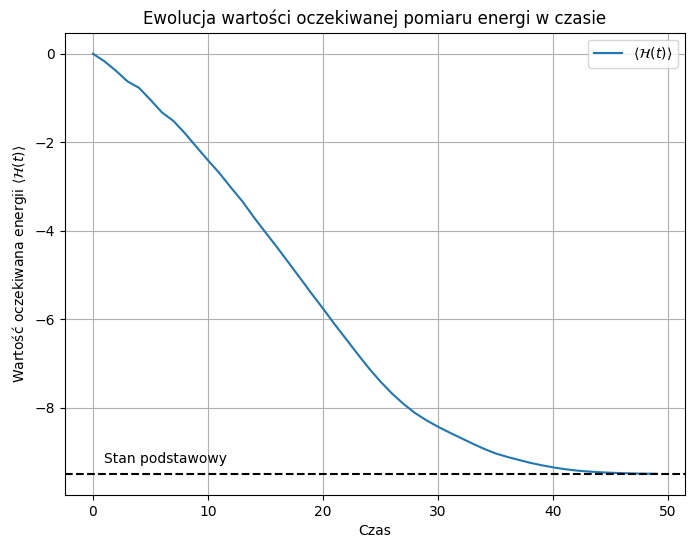

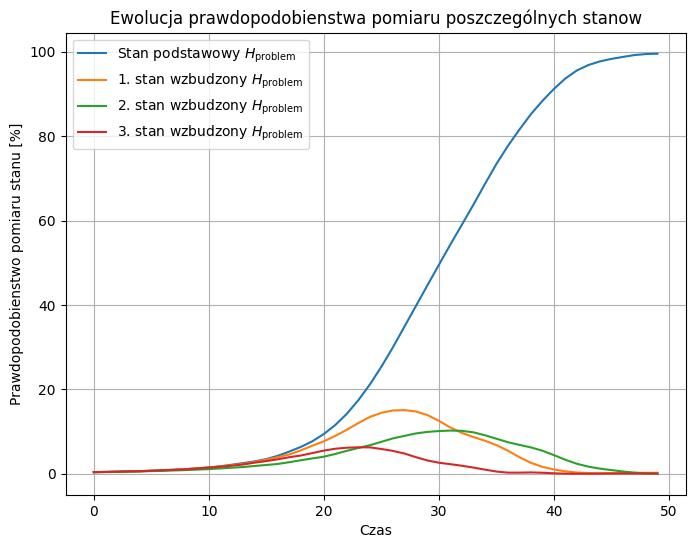

In [3]:
# Ewolucja wartości oczekiwanej w czasie
# Ewolucja prawdopodobienstwa pomiaru stanu w czasie

import matplotlib.pyplot as plt

from qutip.measurement import measure, measurement_statistics
from funkcje_pomocnicze import read_instance_dict, K8


J, h = read_instance_dict(K8.path)

# Czas wyżarzania
T = 50
num_steps = 50

H_t, psi0, H_problem = create_full_hamiltonian(J, h, T)


states, expect = simulate(H_t, psi0, H_problem, T, num_steps)
final_state = states[-1]

# Obrazek wartość oczekiwana
x = range(num_steps)
y1 = expect[0]


plt.figure(figsize=(8, 6))

plt.plot(x, y1, label=r"$\langle \mathcal{H}(t) \rangle$")

plt.axhline(y=-9.5, color='black', linestyle='--')

plt.title("Ewolucja wartości oczekiwanej pomiaru energi w czasie")
plt.xlabel("Czas")
plt.ylabel(r"Wartość oczekiwana energii $\langle \mathcal{H}(t) \rangle$")

plt.text(1, -9.25, "Stan podstawowy", fontsize=10, color='black')
plt.grid(True)
plt.legend()
plt.show()

y2_1 = [measurement_statistics(state, H_problem)[2] for state in states]
y2_2 = [data[:4] for data in y2_1]
y2 = [[x * 100 for x in data] for data in y2_2]

plt.figure(figsize=(8, 6))
plt.plot(x, y2)
plt.title("Ewolucja prawdopodobienstwa pomiaru poszczególnych stanow")
plt.xlabel("Czas")
plt.ylabel("Prawdopodobienstwo pomiaru stanu [%]")
plt.grid(True)
plt.legend([r"Stan podstawowy $H_{\text{problem}}$", r"1. stan wzbudzony $H_{\text{problem}}$", r"2. stan wzbudzony $H_{\text{problem}}$", r"3. stan wzbudzony $H_{\text{problem}}$"])
plt.show()


Tak jak się spodziewaliśmy, wraz z czasem prawdopodobienstwo pomiaru stanu podstawowego rośnie. Jako że pomiar jest probabilistyczny musimy patrzeć na wartość oczekiwaną pomiaru

## Demonstracja adiabatyczności

Tutaj przeprowadzimy wiele eksperymentów, za każdym razem wykonując wyżarzanie kwantowe przez podany czas

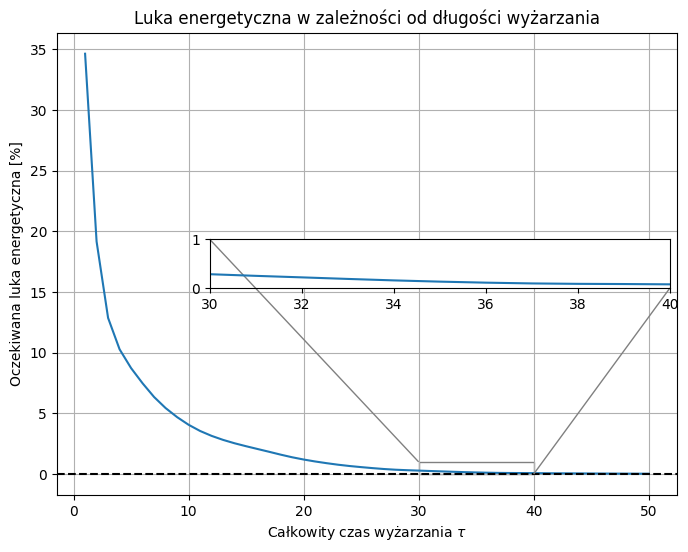

In [4]:
# rysunek dla demonstracji adiabatyczności

import matplotlib.pyplot as plt
from funkcje_pomocnicze import read_instance_dict, K8
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset


J, h = read_instance_dict(K8.path)
num_steps = 10
T = 50
gaps = []
for t in range(1, T+1):
    H_t, psi0, H_problem = create_full_hamiltonian(J, h, t)
    states, expect = simulate(H_t, psi0, H_problem, t, num_steps)
    energy = expect[0][-1]
    gap = (K8.best_energy - energy)/(2*K8.best_energy) * 100
    gaps.append(gap)

x = range(1, T+1)
fig, ax = plt.subplots(figsize=(8, 6))

plt.plot(x, gaps)
plt.axhline(y=0, color='black', linestyle='--')

# Define the region of interest for the zoomed-in plot
x1, x2 = 30, 40  # x-limits for inset
# Compute corresponding y-limits for the sine function
y1, y2 = gaps[x1], gaps[x2]
# To have a little margin around the data points, adjust y-limits
delta_y = 0.1
y1 -= delta_y
y2 += delta_y

axins = zoomed_inset_axes(ax, zoom=4, loc="right")
axins.plot(x, gaps)

# Limit the view to the region of interest
axins.set_xlim(x1, x2)
axins.set_ylim(0, 1)



# Draw lines indicating the area of the inset on the main plot
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.set_title("Luka energetyczna w zależności od długości wyżarzania")
ax.set_xlabel(r"Całkowity czas wyżarzania $\tau$")
ax.set_ylabel("Oczekiwana luka energetyczna [%]")
ax.grid(True)

plt.show()


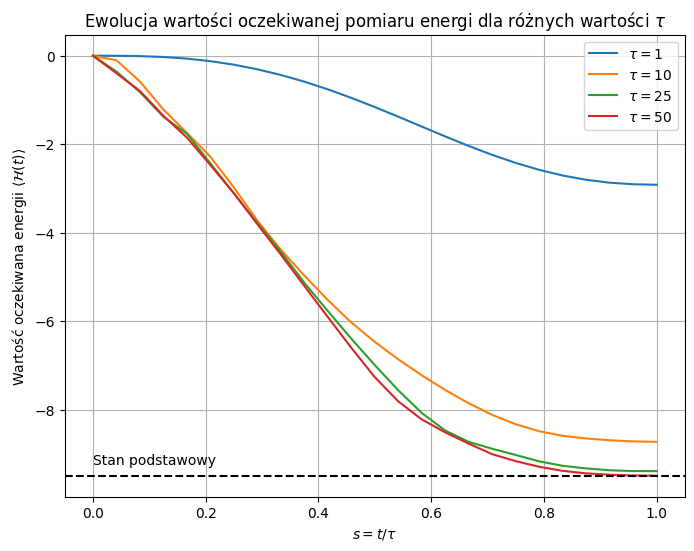

In [5]:
# Demonstracja luki energetycznej dla różnych czasów wyżarzania

import matplotlib.pyplot as plt
from funkcje_pomocnicze import read_instance_dict, K8
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset


J, h = read_instance_dict(K8.path)
num_steps = 25
times = [1, 10, 25, 50]
energies = {}
for t in times:
    H_t, psi0, H_problem = create_full_hamiltonian(J, h, t)
    states, expect = simulate(H_t, psi0, H_problem, t, num_steps)
    energies[t] = expect

x = np.linspace(0, 1, num=num_steps, endpoint=True)
fig, ax = plt.subplots(figsize=(8, 6))

for t in times:
    plt.plot(x, energies[t][0], label=rf"$\tau = ${t}")

plt.text(0, -9.25, "Stan podstawowy", fontsize=10, color='black')
plt.axhline(y=-9.5, color='black', linestyle='--')
plt.legend()
plt.title(r"Ewolucja wartości oczekiwanej pomiaru energi dla różnych wartości $\tau$")
plt.xlabel(r"$s = t / \tau$")
plt.ylabel(r"Wartość oczekiwana energii $\langle \mathcal{H}(t) \rangle$")
plt.grid()
plt.show()

# Bibliografia

* Albash, T., and Lidar, D. A. (2018). Adiabatic quantum computation. *Reviews of Modern Physics, 90(1)*, 015002.
* Tanaka, S., Tamura, R., and Chakrabarti, B. K. (2017). *Quantum spin glasses, annealing and computation.* Cambridge University Press.